In [83]:
import pandas as pd
import plotly.graph_objects as go

# Load energy price data
ENERGY_FILE = 'Sorted_GB_Energy_Data (2).csv'
START_DATE = '2024-08-01'
END_DATE = '2024-12-31'

df_energy = pd.read_csv(ENERGY_FILE, parse_dates=['StartTime'])
df_energy['StartTime'] = df_energy['StartTime'].dt.tz_localize(None)  # Remove timezone
df_energy = df_energy[(df_energy['StartTime'] >= START_DATE) & (df_energy['StartTime'] <= END_DATE)]

# Clean and calculate returns
df_energy['Price'] = df_energy['Price'].fillna(df_energy['Price'].rolling(window=5, min_periods=1).mean())
df_energy = df_energy[df_energy['Price'] > 0]
df_energy['Returns'] = np.log(df_energy['Price'] / df_energy['Price'].shift(1))
df_energy.dropna(subset=['Returns'], inplace=True)

# Load weather data
WEATHER_FILE = 'Updated_Newcastle_Temperature_Data.csv'
df_weather = pd.read_csv(WEATHER_FILE)
df_weather['time'] = pd.to_datetime(df_weather['time'], errors='coerce').dt.tz_localize(None)

# Merge energy and weather data
merged_data = pd.merge_asof(
    df_energy.sort_values('StartTime'),
    df_weather.sort_values('time'),
    left_on='StartTime',
    right_on='time',
    direction='nearest'
)
merged_data.dropna(inplace=True)


C:\Users\vansh\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



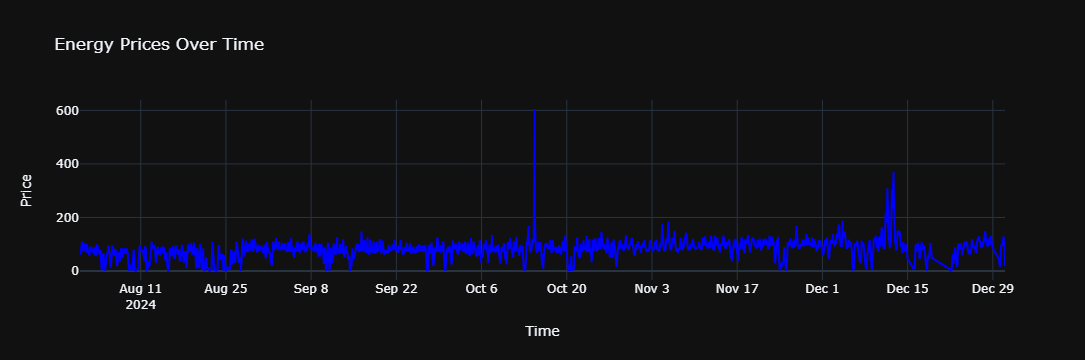

In [84]:
# Plot energy prices over time
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_energy['StartTime'], 
    y=df_energy['Price'], 
    mode='lines', 
    name='Energy Price', 
    line=dict(color='blue')
))

fig.update_layout(
    title='Energy Prices Over Time',
    xaxis_title='Time',
    yaxis_title='Price',
    template='plotly_dark'
)
fig.show()


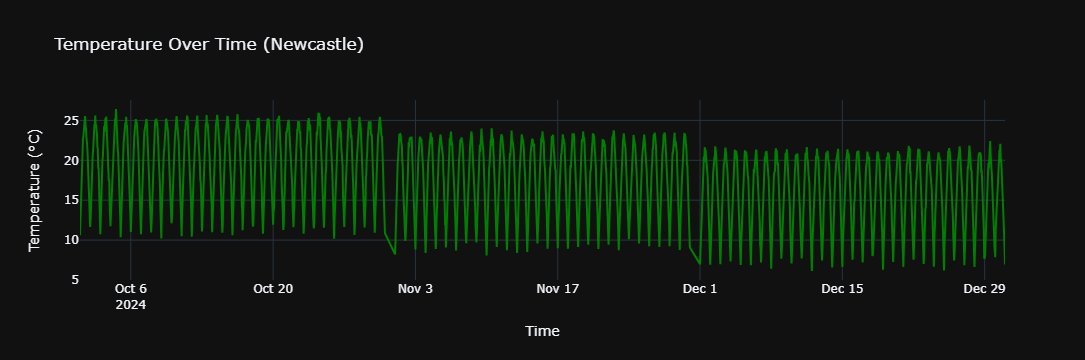

In [85]:
# Plot temperature over time
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_weather['time'], 
    y=df_weather['Temperature_C'], 
    mode='lines', 
    name='Temperature (°C)', 
    line=dict(color='green')
))

fig.update_layout(
    title='Temperature Over Time (Newcastle)',
    xaxis_title='Time',
    yaxis_title='Temperature (°C)',
    template='plotly_dark'
)
fig.show()


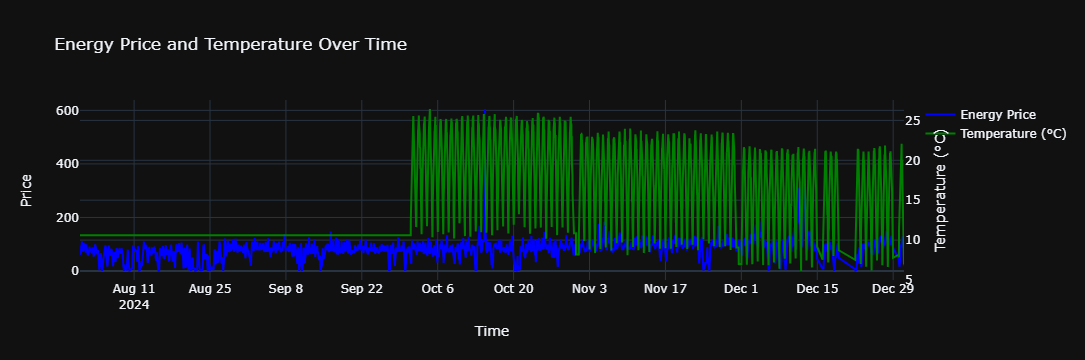

In [86]:
# Combined plot of energy prices and weather
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=merged_data['StartTime'], 
    y=merged_data['Price'], 
    mode='lines', 
    name='Energy Price', 
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=merged_data['StartTime'], 
    y=merged_data['Temperature_C'], 
    mode='lines', 
    name='Temperature (°C)', 
    line=dict(color='green'),
    yaxis='y2'
))

fig.update_layout(
    title='Energy Price and Temperature Over Time',
    xaxis_title='Time',
    yaxis=dict(title='Price'),
    yaxis2=dict(title='Temperature (°C)', overlaying='y', side='right'),
    template='plotly_dark'
)
fig.show()


In [87]:
from arch import arch_model
import numpy as np

# Fit a GARCH(1,1) model to the returns
garch_model = arch_model(df_energy['Returns'], vol='Garch', p=1, q=1)
garch_fitted = garch_model.fit(disp='off')

# Extract conditional volatility
df_energy['Volatility'] = garch_fitted.conditional_volatility

# Define volatility regimes (e.g., High and Low Volatility)
volatility_threshold = np.percentile(df_energy['Volatility'], 25)  # 75th percentile as threshold
df_energy['Regime'] = np.where(df_energy['Volatility'] > volatility_threshold, 'High Volatility', 'Low Volatility')

# Print the GARCH model summary (optional)
print(garch_fitted.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                4304.22
Distribution:                  Normal   AIC:                          -8600.43
Method:            Maximum Likelihood   BIC:                          -8573.09
                                        No. Observations:                 6870
Date:                Sat, Feb 08 2025   Df Residuals:                     6869
Time:                        11:00:14   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         2.0838e-03  1.233e-03      1.690  9.093e-02 

C:\Users\vansh\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08766. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




C:\Users\vansh\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



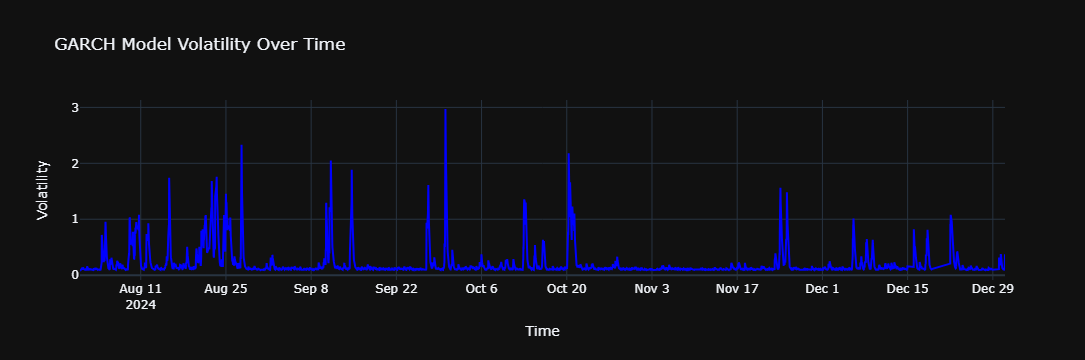

In [88]:
import plotly.graph_objects as go

# Plot GARCH volatility
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_energy['StartTime'],
    y=df_energy['Volatility'],
    mode='lines',
    name='GARCH Volatility',
    line=dict(color='blue')
))

fig.update_layout(
    title='GARCH Model Volatility Over Time',
    xaxis_title='Time',
    yaxis_title='Volatility',
    template='plotly_dark'
)

fig.show()


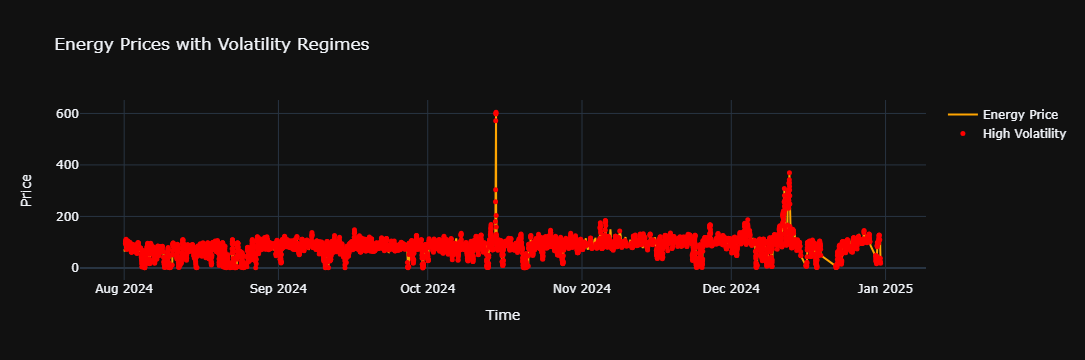

In [89]:
# Add volatility regime overlay
fig = go.Figure()

# Plot energy price
fig.add_trace(go.Scatter(
    x=df_energy['StartTime'],
    y=df_energy['Price'],
    mode='lines',
    name='Energy Price',
    line=dict(color='orange')
))

# Highlight high-volatility periods
high_volatility = df_energy[df_energy['Regime'] == 'High Volatility']
fig.add_trace(go.Scatter(
    x=high_volatility['StartTime'],
    y=high_volatility['Price'],
    mode='markers',
    name='High Volatility',
    marker=dict(color='red', size=5)
))

fig.update_layout(
    title='Energy Prices with Volatility Regimes',
    xaxis_title='Time',
    yaxis_title='Price',
    template='plotly_dark'
)

fig.show()


In [90]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Feature engineering
merged_data['Prev_Price'] = merged_data['Price'].shift(1).fillna(method='bfill')

# Select features and target
X = merged_data[['Prev_Price', 'Temperature_C']]
y = merged_data['Price']

# Splitting data into training (Aug, Sep) and testing (Oct-Dec)
train_data = merged_data[merged_data['StartTime'].dt.month.isin([8, 9])]
test_data = merged_data[merged_data['StartTime'].dt.month.isin([10, 11, 12])]

X_train = train_data[['Prev_Price', 'Temperature_C']]
y_train = train_data['Price']

X_test = test_data[['Prev_Price', 'Temperature_C']]
y_test = test_data['Price']


C:\Users\vansh\AppData\Local\Temp\ipykernel_69260\3838632877.py:9: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [91]:
# Define the ANN model
ann_model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
ann_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train with Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = ann_model.fit(
    X_train, y_train, validation_split=0.2, epochs=200, batch_size=32, callbacks=[early_stop], verbose=1
)


Epoch 1/200


C:\Users\vansh\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4830.2412 - val_loss: 7541.4834
Epoch 2/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 670.1127 - val_loss: 629.2437
Epoch 3/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 256.2881 - val_loss: 58.5614
Epoch 4/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 269.9013 - val_loss: 126.1893
Epoch 5/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 226.3181 - val_loss: 68.3011
Epoch 6/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 215.0348 - val_loss: 58.8998
Epoch 7/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 208.5397 - val_loss: 86.1543
Epoch 8/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 211.0486 - val_loss: 47.7936
Epoch 9/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 191.2394 - val_loss: 48.0024
Epoch 10/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 184.7830 - val_loss: 58.3893
Epoch 11/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 175.3214 - val_loss: 54.5498
Epoch 12/200
69/69 ━━━━━━━━━━━━━━━━━━

In [92]:
# Predict prices using the ANN model
predictions = ann_model.predict(X_test).flatten()

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

# Print metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-Squared (R²) Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")


129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Mean Squared Error (MSE): 1428.2682
Mean Absolute Error (MAE): 28.2239
Root Mean Squared Error (RMSE): 37.7924
R-Squared (R²) Score: -0.0476
Mean Absolute Percentage Error (MAPE): 39.6916%


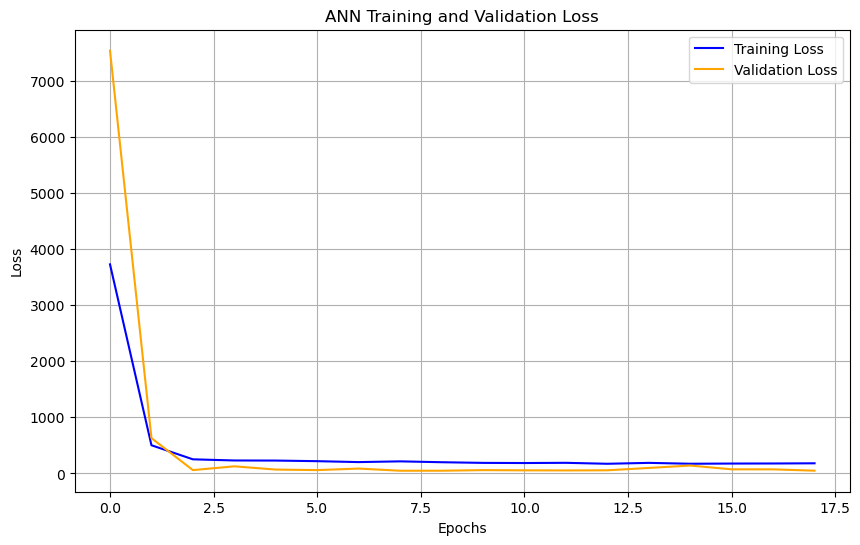

In [93]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('ANN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


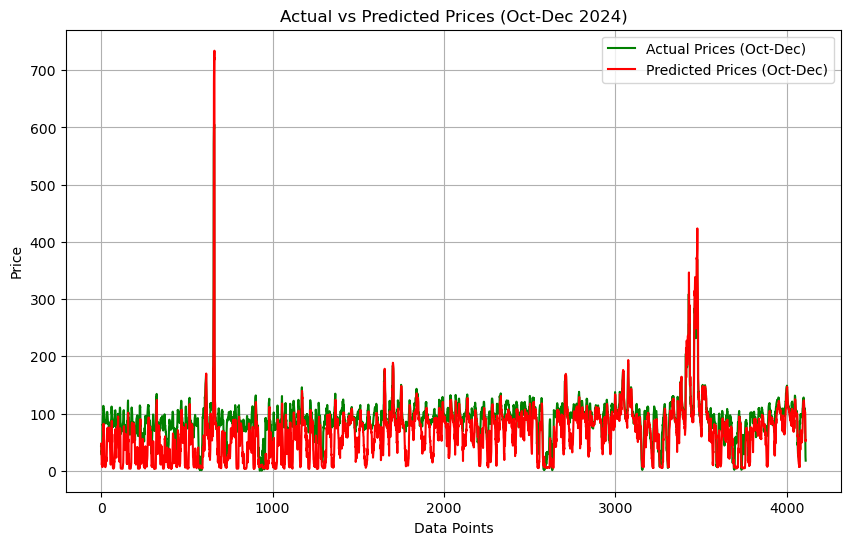

In [94]:
# Filter data for October to December 2024
oct_dec_actual = y_test.reset_index(drop=True)
oct_dec_predictions = pd.Series(predictions, name='Predicted Price')

# Plot Actual vs Predicted Prices
plt.figure(figsize=(10, 6))
plt.plot(oct_dec_actual.index, oct_dec_actual, label='Actual Prices (Oct-Dec)', color='green')
plt.plot(oct_dec_predictions.index, oct_dec_predictions, label='Predicted Prices (Oct-Dec)', color='red')
plt.title('Actual vs Predicted Prices (Oct-Dec 2024)')
plt.xlabel('Data Points')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


In [95]:
# Initialize the signal column with default values
test_data['Predicted_Price'] = predictions  # Add predictions to the test dataset
test_data['Signal'] = 0  # Default signal is 0

# Generate signals for each day based on predicted prices
for date in test_data['StartTime'].dt.date.unique():
    daily_data = test_data[test_data['StartTime'].dt.date == date]
    
    if daily_data.empty:
        continue  # Skip if no data for the day
    
    # Find the lowest and highest predicted price for the day
    lowest_price = daily_data['Predicted_Price'].min()
    highest_price = daily_data['Predicted_Price'].max()

    # Find the indices where these prices occur
    lowest_price_indices = daily_data[daily_data['Predicted_Price'] == lowest_price].index
    highest_price_indices = daily_data[daily_data['Predicted_Price'] == highest_price].index
    
    # Assign signals
    if len(lowest_price_indices) > 0 and len(highest_price_indices) > 0:
        if lowest_price_indices[0] < highest_price_indices[0]:  # Low price before High price
            test_data.loc[lowest_price_indices[0], 'Signal'] = 1  # Buy signal
            test_data.loc[highest_price_indices[0], 'Signal'] = -1  # Sell signal
        else:  # Low price after High price
            test_data.loc[lowest_price_indices[0], 'Signal'] = 2  # Cover short signal
            test_data.loc[highest_price_indices[0], 'Signal'] = -2  # Short signal


C:\Users\vansh\AppData\Local\Temp\ipykernel_69260\4254084250.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vansh\AppData\Local\Temp\ipykernel_69260\4254084250.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [96]:
import plotly.graph_objects as go

# Extract signals
buy_signals = test_data[test_data['Signal'] == 1]
sell_signals = test_data[test_data['Signal'] == -1]
short_signals = test_data[test_data['Signal'] == -2]
cover_short_signals = test_data[test_data['Signal'] == 2]

# Plot the price chart with trading signals
fig = go.Figure()

# Plot price as a line chart
fig.add_trace(go.Scatter(
    x=test_data['StartTime'],
    y=test_data['Price'],
    mode='lines',
    name='Price',
    line=dict(color='orange')
))

# Plot Buy signals as green markers
fig.add_trace(go.Scatter(
    x=buy_signals['StartTime'],
    y=buy_signals['Price'],
    mode='markers',
    name='Buy Signal',
    marker=dict(symbol='triangle-up', color='green', size=10)
))

# Plot Sell signals as red markers
fig.add_trace(go.Scatter(
    x=sell_signals['StartTime'],
    y=sell_signals['Price'],
    mode='markers',
    name='Sell Signal',
    marker=dict(symbol='triangle-down', color='red', size=10)
))

# Plot Short signals as blue markers
fig.add_trace(go.Scatter(
    x=short_signals['StartTime'],
    y=short_signals['Price'],
    mode='markers',
    name='Short Signal',
    marker=dict(symbol='triangle-down', color='blue', size=10)
))

# Plot Cover Short signals as purple markers
fig.add_trace(go.Scatter(
    x=cover_short_signals['StartTime'],
    y=cover_short_signals['Price'],
    mode='markers',
    name='Cover Short Signal',
    marker=dict(symbol='triangle-up', color='purple', size=10)
))

# Update layout with titles and axis labels
fig.update_layout(
    title='Price Chart with Trading Signals (Oct-Dec 2024)',
    xaxis_title='Time',
    yaxis_title='Price',
    hovermode='x unified'
)

fig.show()


C:\Users\vansh\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [97]:
test_data['Regime']= df_energy['Regime']

C:\Users\vansh\AppData\Local\Temp\ipykernel_69260\1513476996.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [98]:
# Initialize variables
initial_cash = 10000  # Initial cash
cash = initial_cash  # Track available cash
long_trades = []  # Store trade details
winning_trades = 0
total_profit = 0
num_long_trades = 0
stop_loss_threshold = -5  # Stop-loss at -5% loss

# Iterate through signals
for i in range(1, len(test_data)):
    # Buy signal in low volatility
    if test_data['Signal'].iloc[i] == 1 and test_data['Regime'].iloc[i] == "Low Volatility":
        buy_price = test_data['Price'].iloc[i]
        buy_time = test_data['StartTime'].iloc[i]
        shares = cash / buy_price  # Use all cash to buy shares

    # If a position is open
    elif 'buy_price' in locals():
        current_price = test_data['Price'].iloc[i]
        current_time = test_data['StartTime'].iloc[i]
        current_profit_pct = (current_price - buy_price) / buy_price * 100  # Profit percentage

        # Close position on stop-loss or sell signal
        if current_profit_pct <= stop_loss_threshold or test_data['Signal'].iloc[i] == -1:
            sell_price = current_price
            sell_time = current_time
            profit = (sell_price - buy_price) * shares
            cash += profit  # Update cash balance

            # Store trade details
            long_trades.append((buy_time, buy_price, sell_time, sell_price, profit, cash))
            num_long_trades += 1
            total_profit += profit
            if profit > 0:
                winning_trades += 1

            del buy_price, shares  # Close position

        # Close position at the end of the day
        elif (i == len(test_data) - 1 or  # Last row
              test_data['StartTime'].iloc[i + 1].date() != test_data['StartTime'].iloc[i].date()):  # End of day
            sell_price = current_price
            sell_time = current_time
            profit = (sell_price - buy_price) * shares
            cash += profit  # Update cash balance

            # Store trade details
            long_trades.append((buy_time, buy_price, sell_time, sell_price, profit, cash))
            num_long_trades += 1
            total_profit += profit
            if profit > 0:
                winning_trades += 1

            del buy_price, shares  # Close position


In [99]:
# Calculate metrics
average_profit = total_profit / num_long_trades if num_long_trades > 0 else 0
win_rate = (winning_trades / num_long_trades) * 100 if num_long_trades > 0 else 0

# Sharpe ratio
returns = [(trade[4] / initial_cash) for trade in long_trades]  # Normalize profit to initial capital
mean_return = np.mean(returns)
std_dev_return = np.std(returns)
sharpe_ratio = (mean_return / std_dev_return) * np.sqrt(252) if std_dev_return > 0 else 0

# Calculate maximum drawdown
portfolio_values = [trade[5] for trade in long_trades]  # Extract portfolio value after each trade
peak = portfolio_values[0]
max_drawdown = 0
for value in portfolio_values:
    peak = max(peak, value)
    drawdown = (peak - value) * 100 / peak
    max_drawdown = max(max_drawdown, drawdown)

# Calculate profit percentage relative to initial cash
profit_percentage = ((cash - initial_cash) / initial_cash) * 100  # Final portfolio gain in percentage

# Print metrics
print(f"Initial Cash: ${initial_cash:,.2f}")
print(f"Final Cash: ${cash:,.2f}")
print(f"Total Profit: ${total_profit:,.2f}")
print(f"Profit Percentage: {profit_percentage:.2f}%")
print(f"Number of Trades: {num_long_trades}")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Average Profit per Trade: ${average_profit:,.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Maximum Drawdown: {max_drawdown:.4f}%")


Initial Cash: $10,000.00
Final Cash: $5,778,245.37
Total Profit: $5,768,245.37
Profit Percentage: 57682.45%
Number of Trades: 22
Win Rate: 81.82%
Average Profit per Trade: $262,192.97
Sharpe Ratio: 9.5363
Maximum Drawdown: 10.9539%


In [ ]:
import matplotlib.pyplot as plt

# Convert trades to a DataFrame
trade_data = pd.DataFrame(long_trades, columns=["Buy Time", "Buy Price", "Sell Time", "Sell Price", "Profit", "Portfolio Value"])

# Plot portfolio value over time
plt.figure(figsize=(12, 6))
plt.plot(trade_data["Sell Time"], trade_data["Portfolio Value"], marker="o", linestyle="-", label="Portfolio Value")
plt.title("Portfolio Value Over Time")
plt.xlabel("Time")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()

# Plot drawdown
drawdown_values = [1 - (value / max(portfolio_values[:i + 1])) for i, value in enumerate(portfolio_values)]
plt.figure(figsize=(12, 6))
plt.plot(trade_data["Sell Time"], drawdown_values, color="red", label="Drawdown")
plt.title("Portfolio Drawdown Over Time")
plt.xlabel("Time")
plt.ylabel("Drawdown (%)")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()
